# AutoEncoder (3) Variational AutoEncoder

- [L1aoXingyu@github](https://github.com/L1aoXingyu)の，[Variational AutoEncoderの実装](https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/Variational_autoencoder.py)の，`nn.Linear`に基づいているコードをJupyterNotebook用に適時修正した．  
- しかし，`nn.Linear`をシンプルに`nn.Conv2D`に変えようと試みたが，学習が上手く行かない．そこで，[3ammor@github](https://github.com/3ammor)の[Variational-Autoencoder-pytorch](https://github.com/3ammor/Variational-Autoencoder-pytorch)を元に変えようとした.  

In [1]:
import torch
import os

## create folder in advance
folder = './data/VAE_img'
if not os.path.isdir(folder):
    os.mkdir(folder)

## set folder in advance
model_path = './data/VAE_autoencoder.pth'

## set some constants for learning
num_epochs = 10
batch_size = 128
learning_rate = 1e-2

## (1) Prepare dataset: MNIST hand-written digits

Almost same with the Simple encoder.

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

## image to tensor
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

## tensor to image
def to_img(x, CHW=(1,28,28)):
    x = x.clamp(0, 1)
    x = x.view(-1, CHW[0], CHW[1], CHW[2])
    return x

## dataset with conversion
dataset_train = MNIST('./data', train=True, download=True, transform=img_transform)

In [3]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

## (2) Prepare model: Variational AutoEncoder

This network is referred from [aidiary@github](https://github.com/aidiary/conv-vae/blob/master/model.py) ...

In [4]:
from torch import nn
from torch.autograd import Variable

class Unflatten(nn.Module):
    def __init__(self, channel, height, width):
        super(Unflatten, self).__init__()
        self.channel = channel
        self.height = height
        self.width = width

    def forward(self, input):
        return input.view(-1, self.channel, self.height, self.width)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 16, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        ## Latent space
        self.fc21 = nn.Linear(512, 2)
        self.fc22 = nn.Linear(512, 2)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 7 * 7 * 16),
            nn.BatchNorm1d(7 * 7 * 16),
            nn.ReLU(),
            Unflatten(16, 7, 7),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc21(x), self.fc22(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:
import torch.nn.functional as F
from torch import optim

## instantiate model
model = VAE()
if torch.cuda.is_available():
    model.cuda() ## send to GPU

reconstruction_function = nn.MSELoss(reduction='sum')

def loss_function(recon_x, x, mu, logvar):
    
    ## MeanSquaredError (reconstruction error)
    MSE = reconstruction_function(recon_x, x)

    # KLD: KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
from torchsummary import summary

## https://github.com/sksq96/pytorch-summary
#summary(model, (1,28,28))
summary(model.encoder, (1, 28, 28))
summary(model.decoder, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 14, 14]           4,608
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,216
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
           Conv2d-10             [-1, 16, 7, 7]           4,608
      BatchNorm2d-11             [-1, 16, 7, 7]              32
             ReLU-12             [-1, 16, 7, 7]               0
          Flatten-13                  [-1, 784]               0
           Linear-14                  [

## (3) Training model

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def visualize(decode):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).cuda()
            x_decoded = decode(z_sample)
            x_decoded = to_img(x_decoded)
            x_decoded = x_decoded.cpu().detach().numpy()

            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    
    return figure

In [8]:
from torchvision.utils import save_image
from tqdm import tqdm

for epoch in range(num_epochs):
    
    ## training
    train_loss = 0
    model.train()

    for batch_idx, data in enumerate(tqdm(dataloader)):
        img, _ = data
        if torch.cuda.is_available():
            img = img.cuda() ## send to GPU

        optimizer.zero_grad()
        
        ## feed-forward
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        train_loss += loss.item()
        
        ## backprop
        loss.backward()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))
    
    ## visualize latent as an image
    model.eval()
    figure = visualize(model.decode)
    
    ## visualization
    '''
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    '''
    
    ## save as image file ...
    figure = torch.tensor(figure)
    pic = to_img(figure, (1, digit_size * n, digit_size * n))
    save_image(pic, '{0}/test_{1}.png'.format(folder, epoch))

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.62it/s]


====> Epoch: 0 Average loss: 216.4109


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.69it/s]


====> Epoch: 1 Average loss: 151.5208


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.58it/s]


====> Epoch: 2 Average loss: 146.1259


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.81it/s]


====> Epoch: 3 Average loss: 143.1622


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.75it/s]


====> Epoch: 4 Average loss: 141.1514


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.67it/s]


====> Epoch: 5 Average loss: 139.3451


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.39it/s]


====> Epoch: 6 Average loss: 137.8703


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.40it/s]


====> Epoch: 7 Average loss: 137.0259


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 22.28it/s]


====> Epoch: 8 Average loss: 136.1386


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 22.27it/s]


====> Epoch: 9 Average loss: 135.3923


In [9]:
## save trained model
torch.save(model.state_dict(), model_path)

## (4) Testing model

In [10]:
## load trained model
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model.eval() ## switch to "evaluate" mode

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten()
    (13): Linear(in_features=784, out_features=512, bias=True)
    (14): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
  )
  (fc2

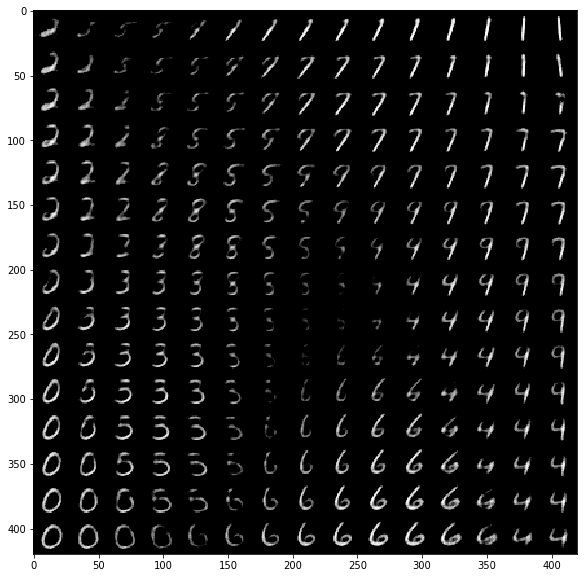

In [11]:
from torchvision.utils import save_image

## final result ...
figure = visualize(model.decode)
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## save as image file ...
figure = torch.tensor(figure)
pic = to_img(figure, (1, digit_size * n, digit_size * n))
save_image(pic, '{0}/test_output.png'.format(folder))

(end)